# Unsupervised Learning

### Fetching Data from Digits

### TODO list :

In [2]:
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as npy
import time
from sklearn.cluster import KMeans


### Fetching data from MlData (optional )

In [5]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist=fetch_mldata('MNIST original',data_home=".")
sampleIndex=npy.random.randint(70000,size=5000)
baseData=mnist.data[sampleIndex]
baseTarget=mnist.target[sampleIndex]


/home/chivunito/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Fetching Digits from datasets

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits=load_digits()
data,target=digits['data'],digits['target']


### Plotting digit

183


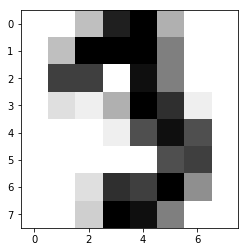

In [8]:
from random import randint

# Plot an image according to a given number
def plotImage(number):
    numberToPlot=data[target==number]
    print(len(numberToPlot))
    if len(numberToPlot):
        index=randint(0,len(numberToPlot)-1)
        imageToPlot=npy.reshape(numberToPlot[index],(8,8))
        plt.imshow(imageToPlot, cmap=plt.cm.gray_r, interpolation='none')
        plt.show()
    else : 
        print("Not a good Number to plot")
plotImage(3)

### K-means classification


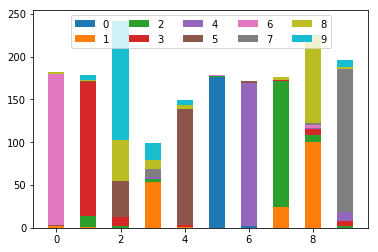

In [103]:
n_clusters=10
clustering=KMeans(n_clusters=n_clusters)
predictedTarget=clustering.fit_predict(data)

matrixToPlot=npy.zeros((10,n_clusters))
for clusterId in range(n_clusters):
    realTarget=target[predictedTarget==clusterId]
    unique, counts = npy.unique(realTarget, return_counts=True)
    occurencesDict=dict(zip(unique, counts))
    for cible,occurence in occurencesDict.items():
#         print(cible,occurence)
        matrixToPlot[cible][clusterId]=occurence

ind = npy.arange(n_clusters)    # the x locations for the groups

labels=[]
bottom=npy.zeros(n_clusters)
for index in range(10):
    p=plt.bar(ind,matrixToPlot[index],bottom=bottom,width=0.5)
    bottom=bottom+matrixToPlot[index]
    labels.append(p)
    plt.legend(p1,str(index))
    
# p2=plt.bar(ind,matrixToPlot[1],bottom=matrixToPlot[0],width=0.2)

plt.legend(labels,[str(i) for i in range(10)],loc='upper center',ncol=5,fancybox=True)
plt.show()

Avec l'exemple ci-dessus, nous avons pris k=10, si on entraine notre classifieur avec les data digits, celle ci sont réparties dans 10 classes différentes. Il est ainsi intéressant de se rendre compte de la répartition de chaque digit dans les classes.<br>
A travers ce plot, on peut se rendre compte que le chiffre 0 est très souvent isolé dans une classe, tandis que les chiffres 1 et 8 sont souvent regroupés dans un même cluster

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### Scoring K-Means
Afin de scorer l'algorithme K-means, nous utiliserons la méthode __.silhouette_score()__ qui calcule la moyenne des "__Silhouette Coefficient__" pour tous les points. <br>
__Silhouette Coefficient__ : Pour un point donné, on va s'intéresser à la distance de celui-ci par rapport à son centroïde (__a__) et la distance avec le centroïde du cluster voisin le plus proche (__b__). <br> 

Le Silhouette Coefficient vaut alors : <br>
__$SlC =  (b - a) / max(a,b) $__ <br>
- Ainsi, si le point est très proche de son centroïde, et le cluster voisin est loin, $SlC => 1$ 

- A l'inverse $SlC => -1 $ signifie que le point n'appartient pas au bon cluster
- $SlC = 0 $ Signifie que les clusters se chevauchent

Nous chercherons donc à avoir un score proche de 1 dans la suite de nos tests

In [123]:
from sklearn.metrics import silhouette_score

def scoreKmeans(k=10, init='k-means++',n_init=60,max_iter=500,data=data) : 
    summary={}
    clustering=KMeans(n_clusters=k, init=init,n_init=n_init,max_iter=max_iter)
    startTime=time.time()
    clustering.fit(data)
    predictedTarget=clustering.predict(data)
    score=silhouette_score(data,predictedTarget)
    summary['time']=time.time()-startTime
    summary['score']=score
    summary['k']=k
    summary['init']=init
    return summary

In [20]:
# Testing
scoreKmeans()

{'init': 'k-means++',
 'k': 10,
 'score': 0.18250104100870407,
 'time': 1.3602423667907715}

## Variation du nombre de clusters & seeds

In [124]:
# clustering=KMeans(n_clusters=10, init='k-means++',n_init=10)
seeds=['random','k-means++']
summaryList=[]
for seed in seeds : 
    for k in range(2,15):
        summary=scoreKmeans(k=k,init=seed)
        summaryList+=[summary]
#     print(summary)

### plotting result

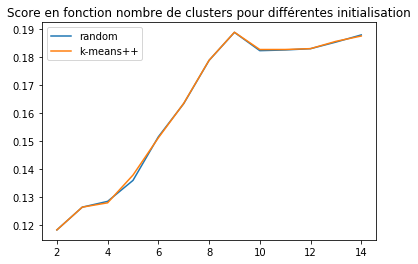

In [125]:
for seed in seeds : 
    score=npy.array([(x['k'],x['score']) for x in summaryList if x['init']==seed])
    plt.plot(score[:,0],score[:,1],label=seed)
plt.legend()
plt.title("Score en fonction nombre de clusters pour différentes initialisation")
plt.show()


D'après notre méthode de scoring, le meilleur nombre de cluster pour maximiser le score de silhouette est 9

### Analyse en composantes principales 

In [149]:
from sklearn.decomposition import PCA

def varPCA(n_components=8,k_constant=9) :
    pca = PCA(n_components=n_components)
    newData=pca.fit_transform(data)
    summary=scoreKmeans(k=k_constant,data=newData)
    return summary

In [150]:
summaryList=[]
for n_components in range(2,40):
    summary=varPCA(n_components=n_components)
    summary['PCA']=n_components
    summaryList+=[summary]

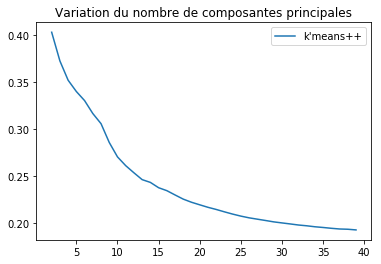

In [130]:
score=npy.array([(x['PCA'],x['score']) for x in summaryList])
plt.plot(score[:,0],score[:,1],label="k'means++")

plt.legend()
plt.title("Variation du nombre de composantes principales")
plt.show()


### BenchMarking K-means

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.22s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.20s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.05s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


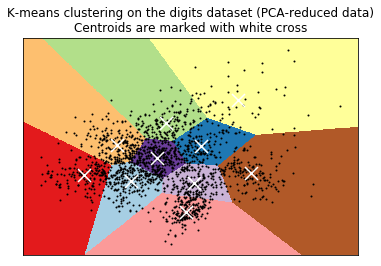

In [139]:
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans


npy.random.seed(42)
digits = load_digits()
data = scale(digits.data)
n_samples, n_features = data.shape
n_digits = len(npy.unique(digits.target))
labels = digits.target
sample_size = 300
print("n_digits: %d, \t n_samples %d, \t n_features %d" % (n_digits, n_samples, n_features))
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
def bench_k_means(estimator, name, data):
    t0 = time.time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (name, (time.time() - t0), estimator.inertia_,
    metrics.homogeneity_score(labels, estimator.labels_),
    metrics.completeness_score(labels, estimator.labels_),
    metrics.v_measure_score(labels, estimator.labels_),
    metrics.adjusted_rand_score(labels, estimator.labels_),
    metrics.adjusted_mutual_info_score(labels, estimator.labels_),
    metrics.silhouette_score(data, estimator.labels_,metric='euclidean',sample_size=sample_size)))
    
bench_k_means(KMeans(init='k-means++',n_clusters=n_digits,n_init=10), name="k-means++", data=data)
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),name="random", data=data)
# # in this case the seeding of the centers is deterministic, hence
# # we run the kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_,n_clusters=n_digits,n_init=1),name="PCA-based",data=data)
print(82 * '_')

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02
# point in the mesh [x_min, x_max]x[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:,
0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:,
1].max() + 1
xx, yy = npy.meshgrid(npy.arange(x_min, x_max, h), npy.arange(y_min,
y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(npy.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
extent=(xx.min(), xx.max(), yy.min(), yy.max()),
cmap=plt.cm.Paired,
aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
marker='x', s=169, linewidths=3,
color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()



Le code qui précède effectue un benchmark du classifieur K-means afin de comparer différentes initialisation du classifieur __('k-means++', 'random', 'PCA' )__ . Nous pouvons retenir différents points importants de ces résultats :
- __homogeneity_score__ : Qualifie l'homogénéité des clusters, c'est à si chaque cluster regroupe des échantillons qui appartiennent à la même classe. Si nous revenons sur le le diagramme en barre affiché en début de ce notebook, bien souvent, il existe un cluster qui regroupe __seulement__ des échantillons de digit dont la valeur est 0. On peut donc dire que ce cluster est homogène et son  __homogeneity_score=1__ <br>
- __completeness_score__ : A l'inverse du score d'homogénéité, cette fois-ci on cherche à qualifier le regroupement d'une classe au sein d'un même cluster. On obtient alors un score proche de 1 si chaque classe ( digit 0 par ex ) est présent dans un seul cluster.
- __v_measure_score__ : Le V-measure score est une résultante des deux scores précédents. Plus le score est proche de 1, plus le classifieur pourra être qualifié d'homogène et Complémentaire. C'est à dire que chaque classe de base a été identifié dans un cluster différent.
- Pour afficher une telle classification, on utilise une PCA sur deux composantes ( axe X,Y ) de manière à pouvoir représenter la répartition des clusters en 2D

- Le classifieur utilisant l'analyse en composantes principales est bien plus rapide en temps d'execution que les autres. Cependant il obtient un score moins bon. 

## Bilan sur K-Means
- K-means est un classifieur dont le but est de minimiser l'inertie ( Somme des carrés de la distance de chaque échantillon par rapport à leur centroîde associé )
- Il est important de noter que K-means est un classifieur non supervisé. En effet, il n'utilise pas les target des samples pour s'entrainer.
- Il n'est pas facile de scorer un tel classificateur car il existe de très nombreuses métriques pour cela. 

### Avantages
- L'une des difficultés dans K-means est de déterminer K, le nombre de cluster. En effet K-means vise à classifier des données non classés. On a en effet aucune connaissance préalable sur les jeux de données et également aucune idée du nombre de classe. Afin de trouver une valeur de K optimale, on peut chercher à maximiser certaines métriques comme nous l'avons fait dans ce Notebook
- L'algorithme K-means est également sensible à la phase d'initialisation, c'est pourquoi il est conseillé de relancer plusieurs fois la classifiation avec différentes graines afin de trouver le meilleur résultat
### Inconvénients
